In [852]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as st
from statsmodels.tsa.arima_model import ARIMA
import warnings
import seaborn as sns  # seaborn画出的图更好看，且代码更简单，缺点是可塑性差
import time
warnings.filterwarnings('ignore')
matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (20, 10)  # 设置输出图片大小
sns.set(color_codes=True)  # seaborn设置背景


df = pd.read_excel('table\表.xlsx', index_col=0)


In [853]:
predict=pd.read_csv('预测结果.csv')
df['预计黄金涨幅']=predict['预计黄金涨幅']
df['预计比特币涨幅']=predict['预计比特币涨幅']
df['比特币残差']=predict['比特币残差']
df['黄金残差']=predict['黄金残差']
df['黄金预测方差'] = predict['黄金预测方差']
df['比特币预测方差'] = predict['比特币预测方差']
df.to_excel('table/result.xlsx')


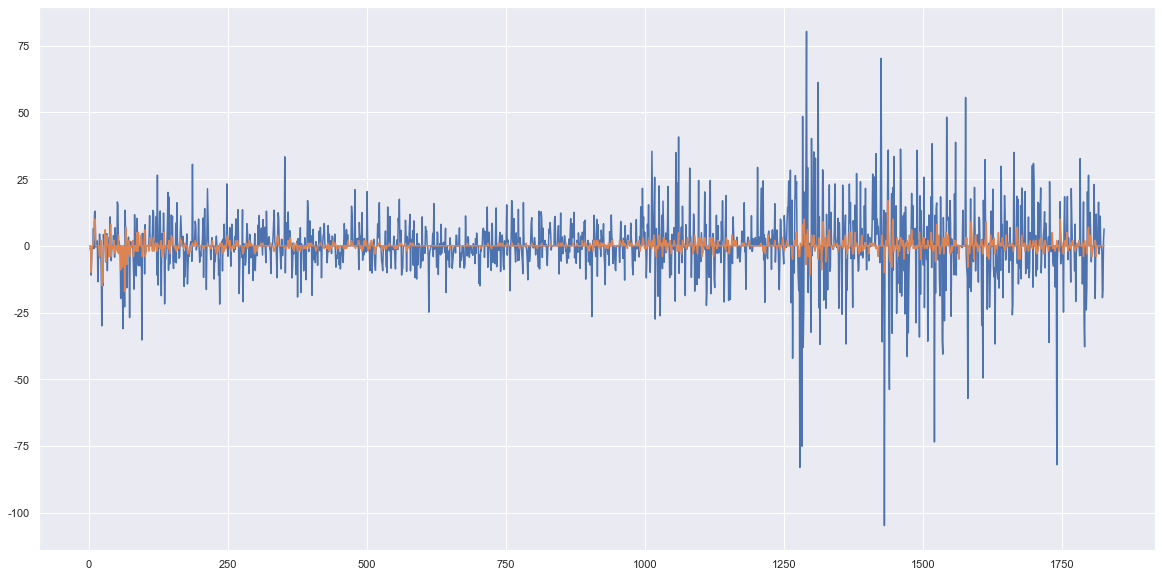

In [854]:
df['USD (PM)'][1:].diff(1).dropna().plot()
df['预计黄金涨幅'][1:].plot()
plt.savefig('img/预计黄金涨幅.png')
plt.show()


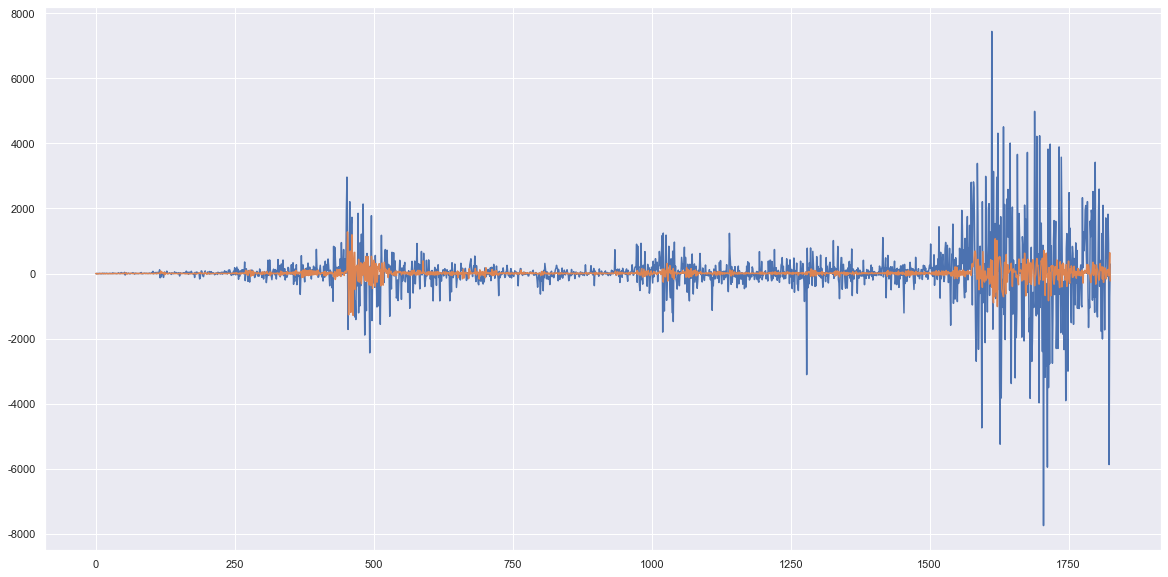

In [855]:
df['Value'].diff(1).dropna().plot()
df['预计比特币涨幅'].plot()
plt.savefig('img/预计比特币涨幅.png')
plt.show()


In [856]:
def zeros(x):
    if x == 0:
        return np.nan
    else:
        return x


In [891]:
df['黄金残差'] = df['黄金残差'].apply(zeros).fillna(method='ffill')
df['预计黄金涨幅'] = df['预计黄金涨幅'].apply(zeros).fillna(method='ffill')
# df=df.fillna()
max_, min_ = df['黄金残差'].max(), df['黄金残差'].min()
df['黄金残差'] = df['黄金残差'].apply(lambda x: (x-min_)/(max_-min_))
max_, min_ = df['比特币残差'].max(), df['比特币残差'].min()
df['比特币残差'] = df['比特币残差'].apply(lambda x: (x-min_)/(max_-min_))
max_, min_ = df['预计黄金涨幅'].max(), df['预计黄金涨幅'].min()
df['预计黄金涨幅归一化'] = df['预计黄金涨幅'].apply(lambda x: (x-min_)/(max_-min_))
max_, min_ = df['预计比特币涨幅'].max(), df['预计比特币涨幅'].min()
df['预计比特币涨幅归一化'] = df['预计比特币涨幅'].apply(lambda x: (x-min_)/(max_-min_))

max_, min_ = df['比特币6日乖离率'].max(), df['比特币6日乖离率'].min()
df['比特币6日乖离率'] = df['比特币6日乖离率'].apply(lambda x: (x-min_)/(max_-min_))
max_, min_ = df['黄金12日乖离率'].max(), df['黄金12日乖离率'].min()
df['黄金12日乖离率'] = df['黄金12日乖离率'].apply(lambda x: (x-min_)/(max_-min_))

max_, min_ = df['比特币预测方差'].max(), df['比特币预测方差'].min()
df['比特币预测方差'] = df['比特币预测方差'].apply(lambda x: (x-min_)/(max_-min_))
max_, min_ = df['黄金预测方差'].max(), df['黄金预测方差'].min()
df['黄金预测方差'] = df['黄金预测方差'].apply(lambda x: (x-min_)/(max_-min_))

df[['预计黄金涨幅归一化', '黄金残差', '黄金12日乖离率']].to_csv('gold_analysis.csv')
df[['预计比特币涨幅归一化', '比特币残差', '比特币6日乖离率']].to_csv('bitcoin_analysis.csv')


In [1717]:
df['黄金买入评分'] = 0.17*0.2*df['预计黄金涨幅归一化']+df['黄金牛市']*0.83*0.2-0.74*abs(df['黄金12日乖离率']-0.5)-0.06*df['黄金残差']
df['比特币买入评分'] = 0.17*0.2*df['预计比特币涨幅归一化']+df['比特币牛市'] * \
    0.83*0.2-0.74*abs(df['比特币6日乖离率']-0.5)-0.06*df['比特币残差']


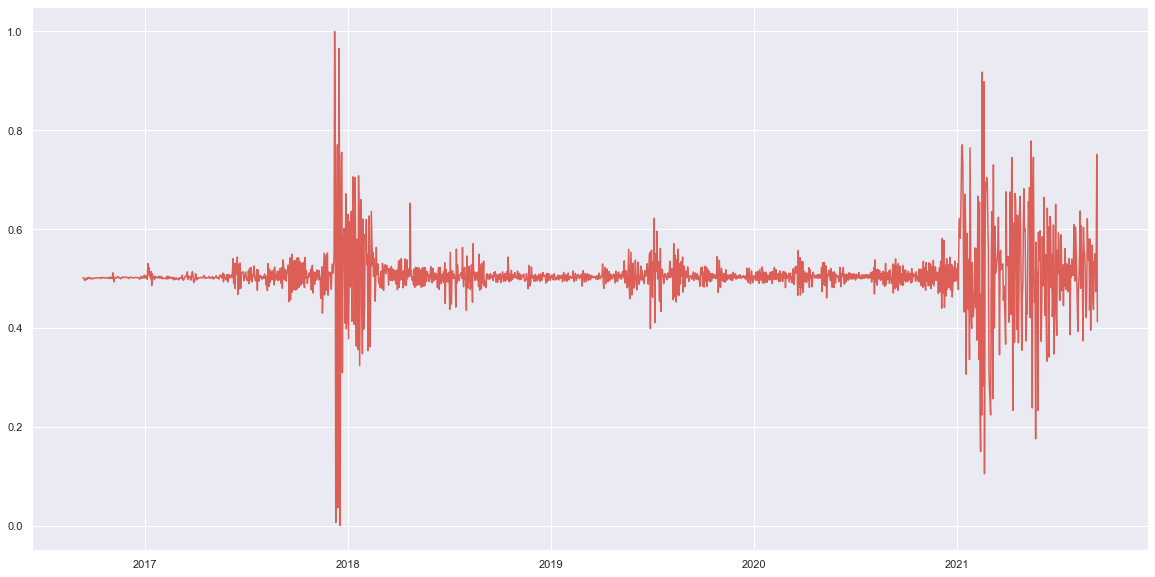

In [1718]:
plt.plot(df['Date'], df['预计比特币涨幅归一化'])


## 归一化

In [1719]:
max_, min_ = df['黄金买入评分'].max(), df['黄金买入评分'].min()
df['黄金买入评分'] = df['黄金买入评分'].apply(lambda x: (x-min_)/(max_-min_))

max_, min_ = df['比特币买入评分'].max(), df['比特币买入评分'].min()
df['比特币买入评分'] = df['比特币买入评分'].apply(lambda x: (x-min_)/(max_-min_))


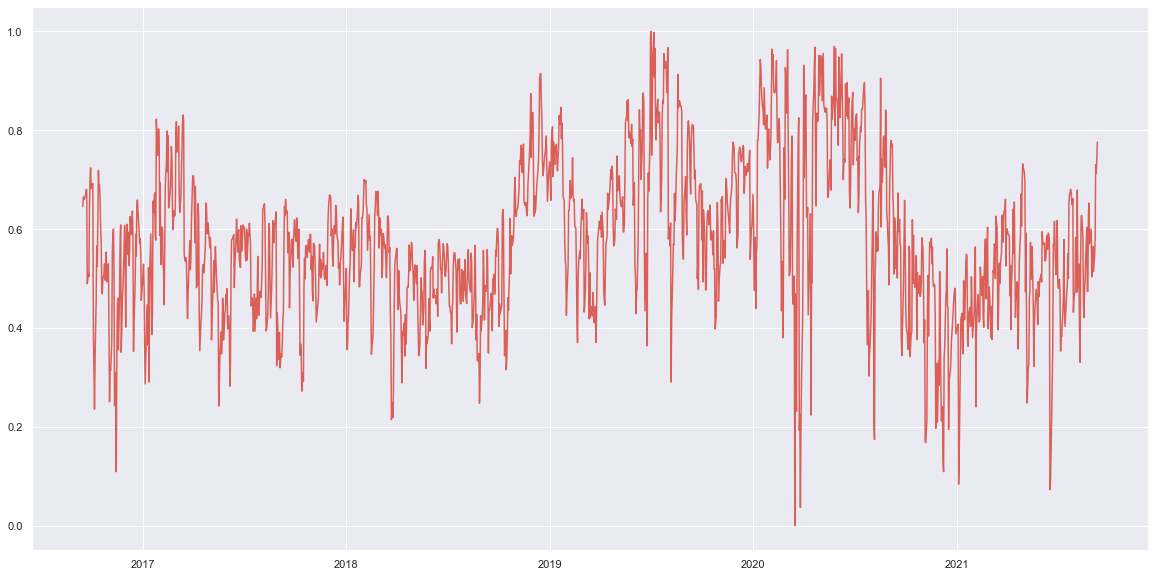

In [1720]:
plt.plot(df['Date'], df['黄金买入评分'])
# plt.savefig('比特币买入评分.png')
plt.show()


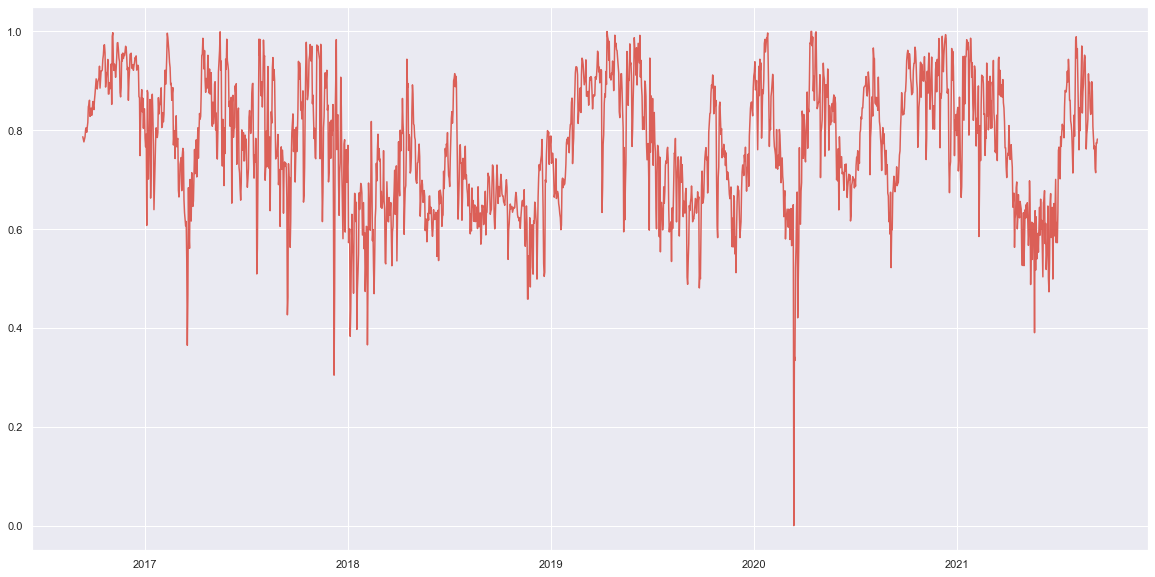

In [1721]:
plt.plot(df['Date'], df['比特币买入评分'])
plt.savefig('table/比特币买入评分图.png')
plt.show()


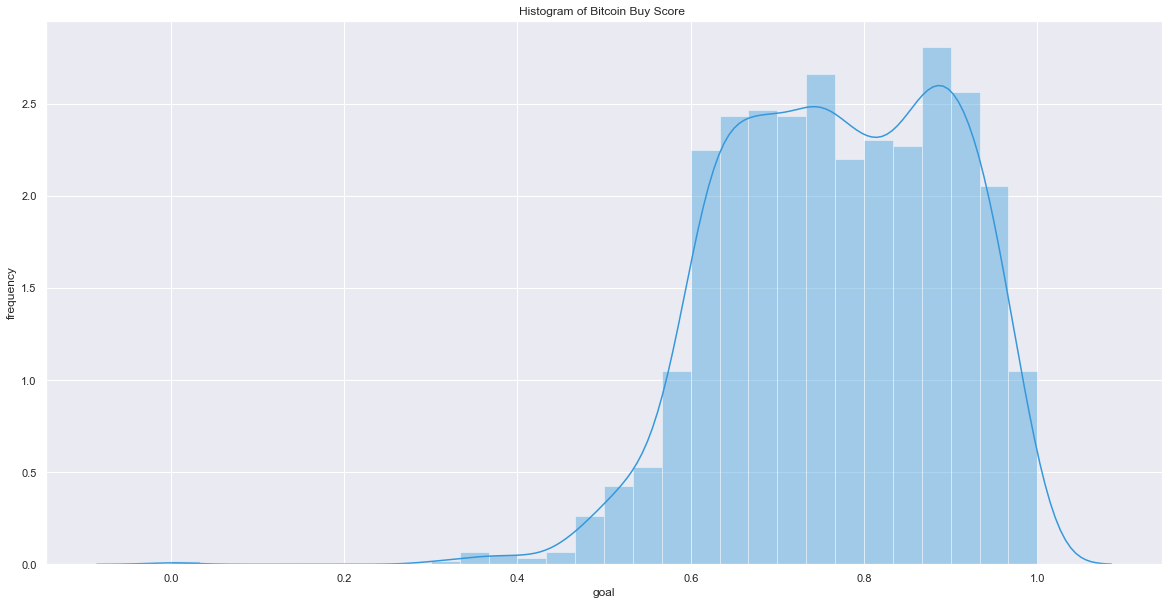

In [1722]:
import seaborn as sns
sns.set_palette("hls")  # 设置所有图的颜色，使用hls色彩空间
sns.distplot(df['比特币买入评分'], color="#3498db", bins=30, kde=True)
plt.xlabel('goal') #绘制x轴
plt.ylabel('frequency')  # 绘制y轴
plt.title(r'Histogram of Bitcoin Buy Score ')  # 中文标题 u'xxx'
plt.savefig('./img/比特币直方图.png')
plt.show()


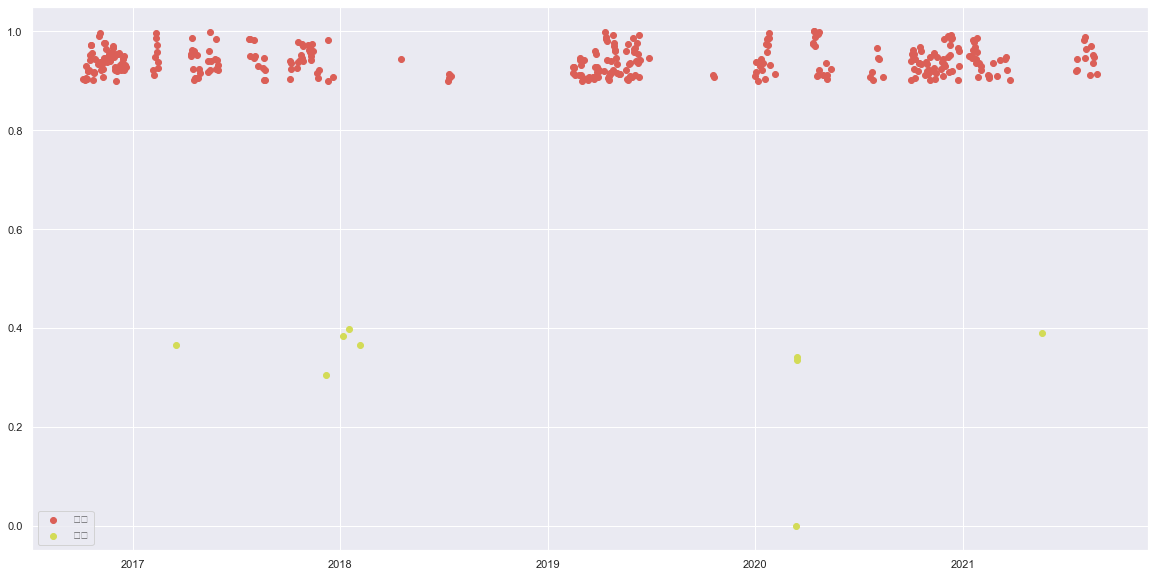

In [1735]:
bh =0.9
bl =0.42
plt.scatter(df['Date'][df['比特币买入评分'] > bh], df['比特币买入评分']
            [df['比特币买入评分'] > bh], label='买入')
plt.scatter(df['Date'][df['比特币买入评分'] < bl], df['比特币买入评分']
            [df['比特币买入评分'] < bl], label='卖出')
plt.legend()
plt.savefig('table/比特币评分对比图.png')
plt.show()


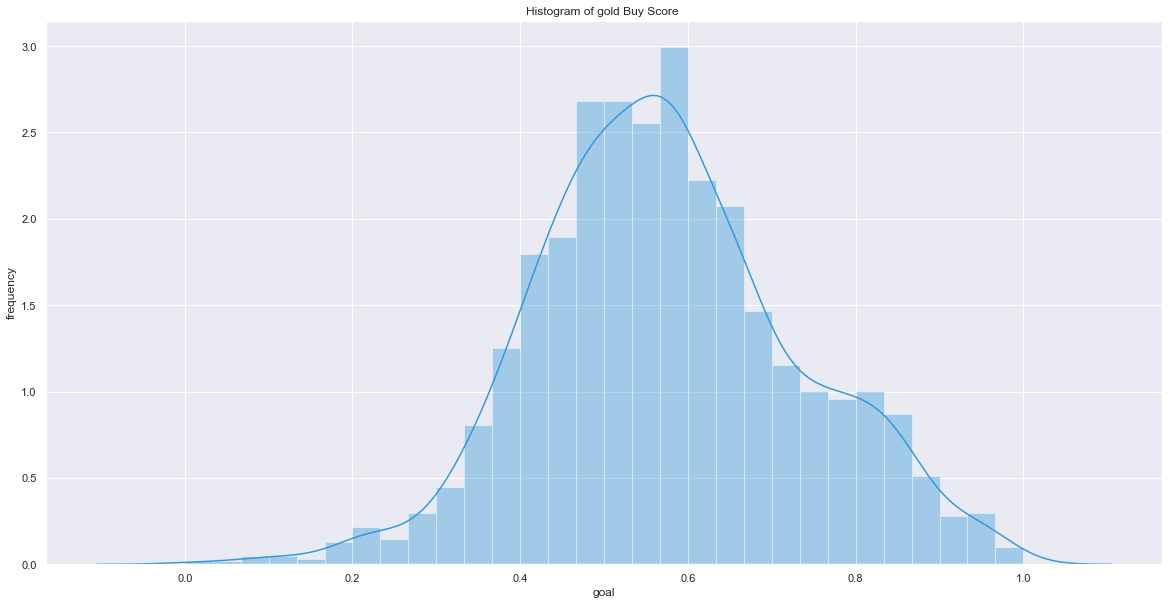

In [1736]:
import seaborn as sns
sns.set_palette("hls")  # 设置所有图的颜色，使用hls色彩空间
sns.distplot(df['黄金买入评分'], color="#3498db", bins=30, kde=True)
plt.xlabel('goal')  # 绘制x轴
plt.ylabel('frequency')  # 绘制y轴
plt.title(r'Histogram of gold Buy Score ')  # 中文标题 u'xxx'
plt.savefig('./img/黄金直方图.png')
plt.show()


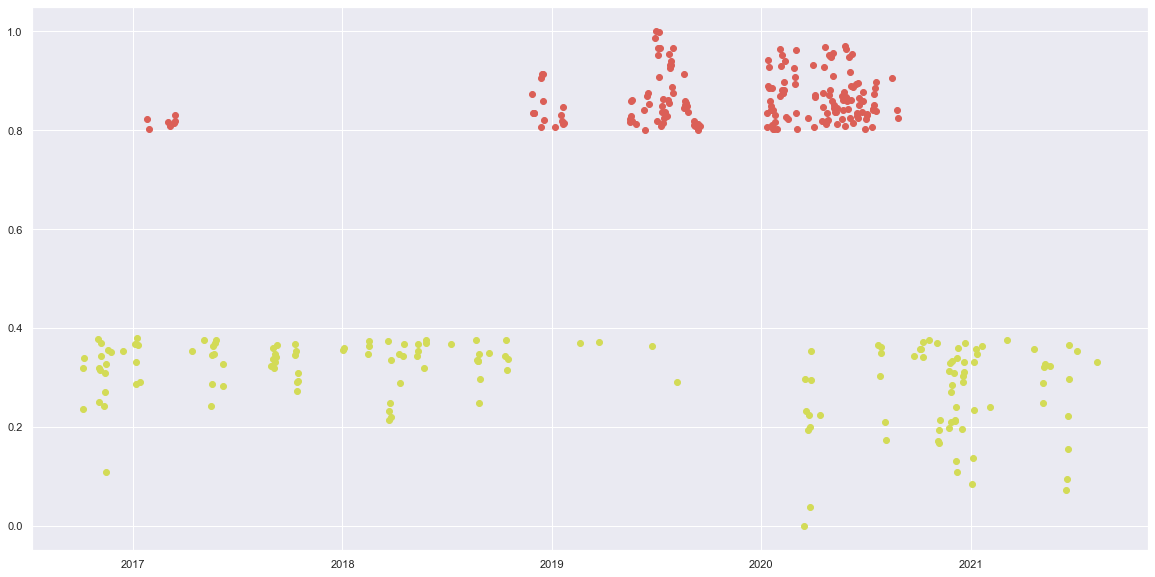

In [1756]:

gh = 0.8
gl = 0.38
plt.scatter(df['Date'][df['黄金买入评分'] > gh], df['黄金买入评分'][df['黄金买入评分'] > gh])
plt.scatter(df['Date'][df['黄金买入评分'] < gl], df['黄金买入评分'][df['黄金买入评分'] < gl])
plt.savefig('table/黄金评分对比图.png')
plt.show()


In [1757]:
for i in df.index[1:]:
    df['黄金涨幅'][i] = df['USD (PM)'][i]-df['USD (PM)'][i-1]
    df['比特币涨幅'][i] = df['Value'][i]-df['Value'][i-1]


In [1758]:
df['总资产'][0] = 1000.0
df['现金持有份额'][0] = 1000.0
df['黄金持有份额'][0] = 0.0
for i in df.columns[1:]:
    df[i] = df[i].astype('float')


In [1759]:
# 黄金买0.58，卖0.3,中间不动
# 比特币买0.71，卖56

per_gold = 0.01
per_bt = 0.02

for i in range(1, df.shape[0]):
    bt = df['比特币买入评分'][i]
    df['当前黄金利润'][i] = df['当前黄金利润'][i-1]+df['黄金涨幅'][i-1]*df['黄金持有份额'][i-1]
    df['当前比特币利润'][i] = df['当前比特币利润'][i-1]+df['比特币涨幅'][i-1]*df['比特币持有份额'][i-1]
    df['黄金持有份额'][i] = df['黄金持有份额'][i-1]
    df['现金持有份额'][i] = df['现金持有份额'][i-1]
    df['比特币持有份额'][i] = df['比特币持有份额'][i-1]

    if df['DealDay'][i]:  # 判断交易日
        gold = df['黄金买入评分'][i]
        if gold > gh:
            if bt > bh:  # 两者都可买入时
                if gold-gh > (bt-bh):  #买入黄金
                    df['黄金持有份额'][i] = df['黄金持有份额'][i-1]+df['现金持有份额'][i-1] * \
                        gold*(1-per_gold)/df['USD (PM)'][i-1]
                    df['现金持有份额'][i] = df['现金持有份额'][i-1]-df['现金持有份额'][i-1]*gold
#                     print('两者选黄金',df['黄金持有份额'][i],df['现金持有份额'][i],df['现金持有份额'][i-1],gold,1-per_gold,df['USD (PM)'][i-1])
                else:  # 买入比特币
                    df['比特币持有份额'][i] = df['比特币持有份额'][i-1] + \
                        df['现金持有份额'][i-1]*bt*(1-per_bt)/df['Value'][i-1]
                    df['现金持有份额'][i] = df['现金持有份额'][i-1]-df['现金持有份额'][i-1]*bt
#                     print('两者选比特币',df['比特币持有份额'][i],df['现金持有份额'][i])
            else:  # 只能买黄金时
                df['黄金持有份额'][i] = df['黄金持有份额'][i-1]+df['现金持有份额'][i-1] * \
                    gold*(1-per_gold)/df['USD (PM)'][i-1]
                df['现金持有份额'][i] = df['现金持有份额'][i-1]-df['现金持有份额'][i-1]*gold
#                 print('只能买黄金',df['黄金持有份额'][i])
        if gold < gl:  #卖出黄金
            df['黄金持有份额'][i] = df['黄金持有份额'][i-1]-df['黄金持有份额'][i-1]*(1+gold-gl)
            
            df['现金持有份额'][i] = df['现金持有份额'][i-1]+df['黄金持有份额'][i-1] * \
                (1+gold-gl)*(1-per_gold)*df['USD (PM)'][i-1]
#             print('卖黄金',df['黄金持有份额'][i],df['现金持有份额'][i])
        continue

    if bt > bh:  # 买入比特币
        df['比特币持有份额'][i] = df['比特币持有份额'][i-1] + \
            df['现金持有份额'][i-1]*bt*2*(1-per_bt)/df['Value'][i-1]
        df['现金持有份额'][i] = df['现金持有份额'][i-1]-df['现金持有份额'][i-1]*bt
#         print('买比特币',df['比特币持有份额'][i],df['现金持有份额'][i])
    if bt < bl:  # 卖出比特币
        df['比特币持有份额'][i] = df['比特币持有份额'][i-1]-df['比特币持有份额'][i-1]*(1+bt-bl)
        df['现金持有份额'][i] = df['现金持有份额'][i-1]+df['比特币持有份额'][i-1] * \
            (1+bt-bl)*(1-per_bt)*df['Value'][i-1]
#         print('卖比特币',df['比特币持有份额'][i],df['现金持有份额'][i])


In [1770]:
assets=[]
for per_gold in np.arange(0.01,0.11,0.01):
    for per_bt in np.arange(0.01,0.21,0.01):
        df['总资产'][0]=1000.0
        df['现金持有份额'][0]=1000.0
        df['黄金持有份额'][0]=0.0
        for i in range(1,df.shape[0]):
            bt = df['比特币买入评分'][i]
            df['当前黄金利润'][i]=df['当前黄金利润'][i-1]+df['黄金涨幅'][i-1]*df['黄金持有份额'][i-1]
            df['当前比特币利润'][i]=df['当前比特币利润'][i-1]+df['比特币涨幅'][i-1]*df['比特币持有份额'][i-1]
            df['黄金持有份额'][i]=df['黄金持有份额'][i-1]
            df['现金持有份额'][i]=df['现金持有份额'][i-1]
            df['比特币持有份额'][i]=df['比特币持有份额'][i-1]
            if df['DealDay'][i]:  # 判断交易日
                gold = df['黄金买入评分'][i]
                if gold > gh:
                    if bt > bh:# 两者都可买入时
                        if gold-gh > (bt-bh)*2:  # 买入黄金
                            df['黄金持有份额'][i]=df['黄金持有份额'][i-1]+df['现金持有份额'][i-1]*gold*(1-per_gold)/df['USD (PM)'][i-1]
                            df['现金持有份额'][i]=df['现金持有份额'][i-1]-df['现金持有份额'][i-1]*gold
        #                     print('两者选黄金',df['黄金持有份额'][i],df['现金持有份额'][i],df['现金持有份额'][i-1],gold,1-per_gold,df['USD (PM)'][i-1])
                        else:  # 买入比特币
                            df['比特币持有份额'][i]=df['比特币持有份额'][i-1]+df['现金持有份额'][i-1]*bt*(1-per_bt)/df['Value'][i-1]
                            df['现金持有份额'][i]=df['现金持有份额'][i-1]-df['现金持有份额'][i-1]*bt
        #                     print('两者选比特币',df['比特币持有份额'][i],df['现金持有份额'][i])
                    else: # 只能买黄金时
                        df['黄金持有份额'][i]=df['黄金持有份额'][i-1]+df['现金持有份额'][i-1]*gold*(1-per_gold)/df['USD (PM)'][i-1]
                        df['现金持有份额'][i]=df['现金持有份额'][i-1]-df['现金持有份额'][i-1]*gold
        #                 print('只能买黄金',df['黄金持有份额'][i])
                if gold<gl:  # 买入黄金
                    df['黄金持有份额'][i]=df['黄金持有份额'][i-1]-df['黄金持有份额'][i-1]*(1+gold-gl)
                    df['现金持有份额'][i] = df['现金持有份额'][i-1]+df['黄金持有份额'][i-1] * \
                        (1+gold-gl)*(1-per_gold)*df['USD (PM)'][i-1]
        #             print('卖黄金',df['黄金持有份额'][i],df['现金持有份额'][i])
                continue    
            if bt > bh:  # 买入比特币
                df['比特币持有份额'][i]=df['比特币持有份额'][i-1]+df['现金持有份额'][i-1]*bt*2*(1-per_bt)/df['Value'][i-1]
                df['现金持有份额'][i]=df['现金持有份额'][i-1]-df['现金持有份额'][i-1]*bt
        #         print('买比特币',df['比特币持有份额'][i],df['现金持有份额'][i])
            if bt < bl:  # 卖出比特币
                df['比特币持有份额'][i]=df['比特币持有份额'][i-1]-df['比特币持有份额'][i-1]*(1+gold-bl)
                df['现金持有份额'][i]=df['现金持有份额'][i-1]+df['比特币持有份额'][i-1]*(1+gold-bl)*(1-per_gold)*df['Value'][i-1]
        #         print('卖比特币',df['比特币持有份额'][i],df['现金持有份额'][i])
        df['总资产']=df['黄金持有份额']*df['USD (PM)']+df['比特币持有份额']*df['Value']+df['现金持有份额']
        assets.append(df['总资产'][len(df)-1])
assets


[320257.63142453023,
 310451.996247733,
 300848.4969138102,
 291445.0291012634,
 282239.48848859424,
 273229.770754304,
 264413.7715768949,
 255789.38663486787,
 247354.51160672467,
 239107.04217096698,
 231044.87400609633,
 223165.90279061426,
 215468.02420302236,
 207949.13392182236,
 200607.1276255157,
 193439.90099260394,
 186445.34970158894,
 179621.36943097183,
 172965.8558592547,
 166476.70466493865,
 298200.99456615775,
 289068.78832536575,
 280124.8734882726,
 271367.28948021063,
 262794.07572651183,
 254403.2716525082,
 246192.91668353236,
 238161.0502449165,
 230305.71176199272,
 222624.9406600928,
 215116.7763645495,
 207779.25830069464,
 200610.42589386096,
 193608.31856937963,
 186770.97575258382,
 180096.4368688054,
 173582.7413433765,
 167227.92860162936,
 161030.03806889613,
 154987.109170509,
 277508.68738087517,
 269008.3678249916,
 260683.34699501938,
 252531.79924227245,
 244551.89891806504,
 236741.82037371094,
 229099.73796052457,
 221623.82602981952,
 214312.258

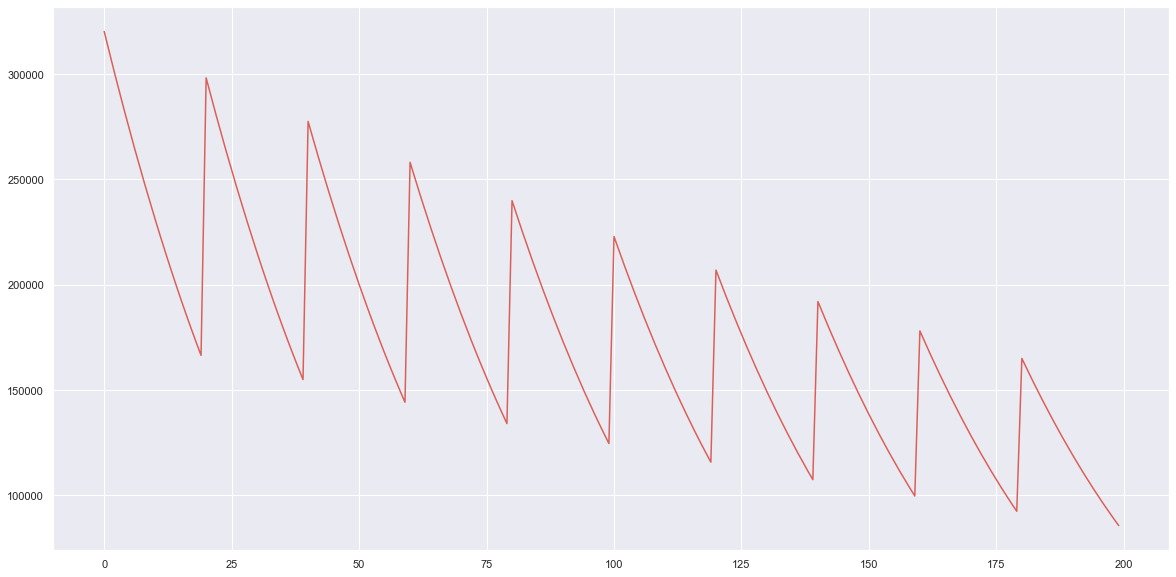

In [1772]:
plt.plot(assets)
plt.savefig('不同手续费最大总资产走势图.png')
plt.show()


In [1773]:
gold_ = []
bt_ = []
for per_gold in np.arange(0.01, 0.11, 0.01):
    for per_bt in np.arange(0.01, 0.21, 0.01):
        gold_.append(per_gold)
        bt_.append(per_bt)


In [1774]:
df_a = pd.DataFrame()
df_a['黄金佣金'] = gold_
df_a['比特币佣金'] = bt_
df_a['总资产'] = assets
df_a.head()


,黄金佣金,比特币佣金,总资产
0,0.01,0.01,320257.631425
1,0.01,0.02,310451.996248
2,0.01,0.03,300848.496914
3,0.01,0.04,291445.029101
4,0.01,0.05,282239.488489


In [1775]:
df_a.to_excel('佣金-总资产表.xlsx')


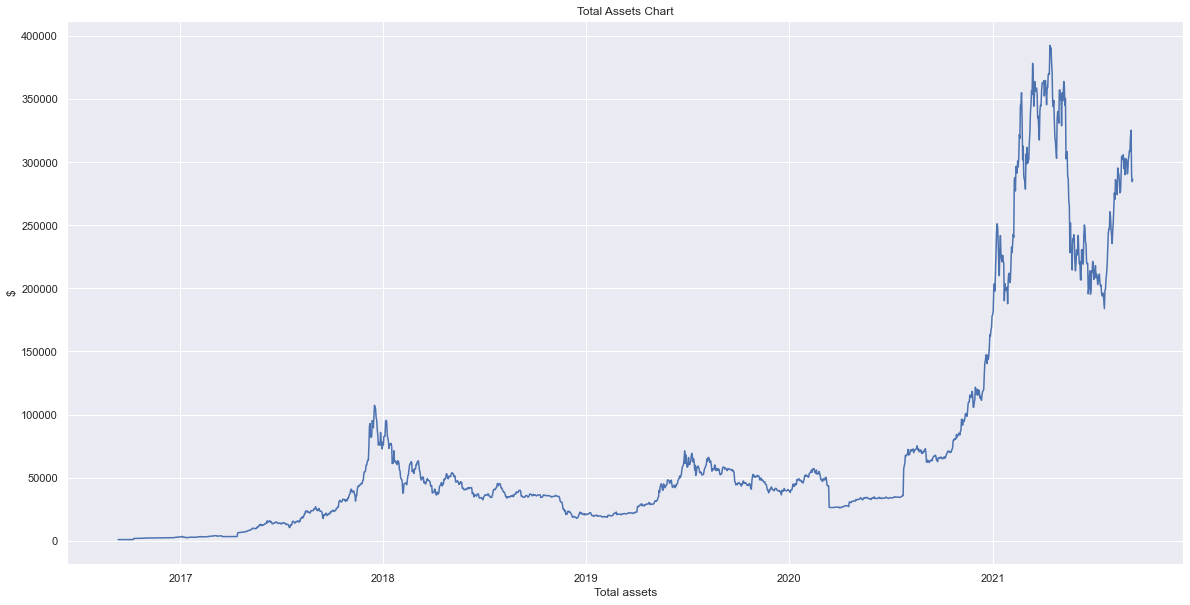

In [1760]:
df['总资产'] = df['黄金持有份额']*df['USD (PM)']+df['比特币持有份额']*df['Value']+df['现金持有份额']
plt.plot(df['Date'], df['总资产'],'b-')
plt.xlabel('Total assets')  # 绘制x轴
plt.ylabel('$')  # 绘制y轴
plt.title(r'Total Assets Chart')  # 中文标题 u'xxx'
plt.savefig('img/总资产走势图.png')
plt.show()


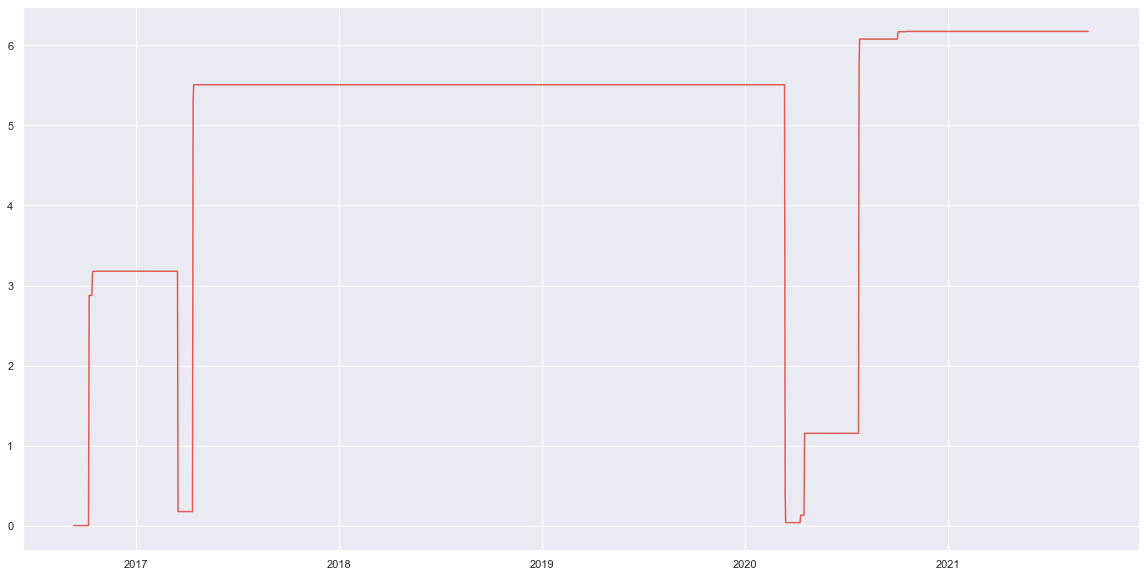

In [1761]:
plt.plot(df['Date'],df['比特币持有份额'])
plt.savefig('img/比特币持有份额走势图.png')
plt.show()


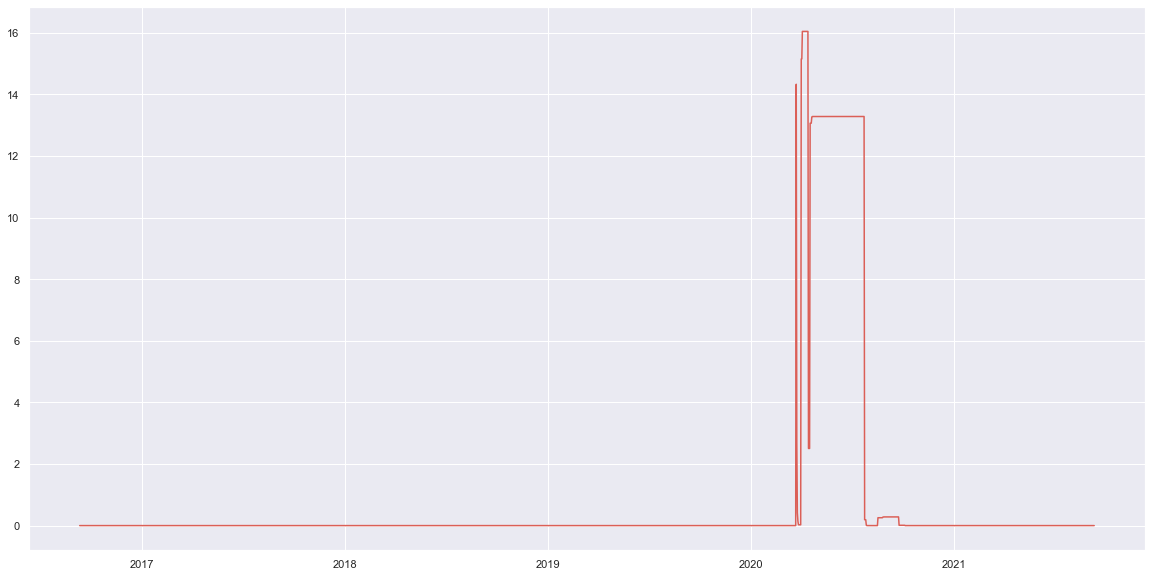

In [1762]:
plt.plot(df['Date'], df['黄金持有份额'])
plt.savefig('img/黄金持有份额走势图.png')
plt.show()


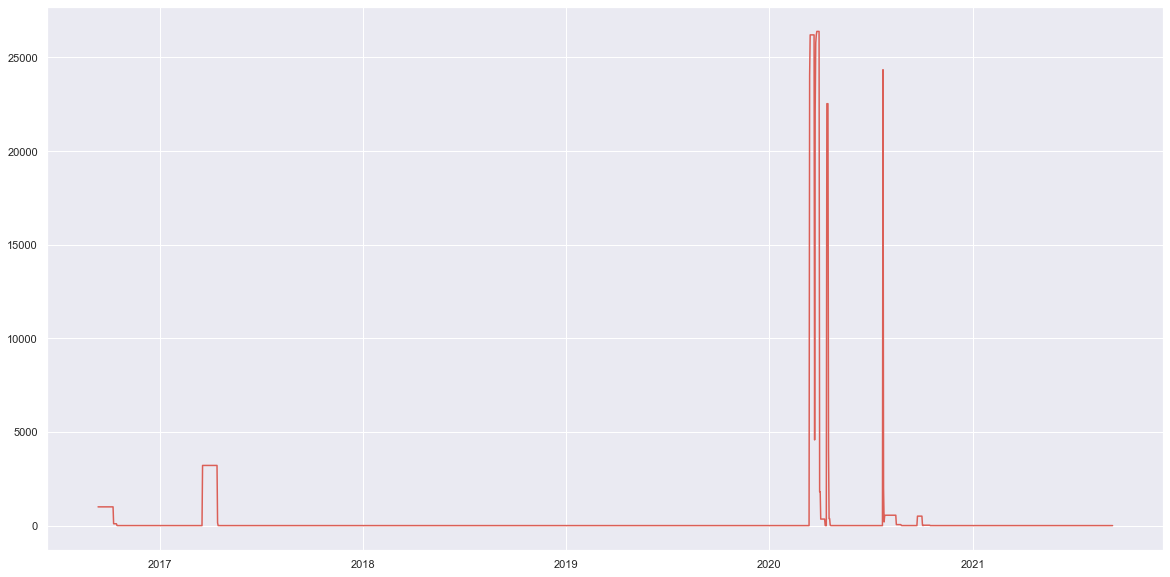

In [1763]:
plt.plot(df['Date'], df['现金持有份额'])
plt.savefig('img/现金持有份额额走势图.png')
plt.show()


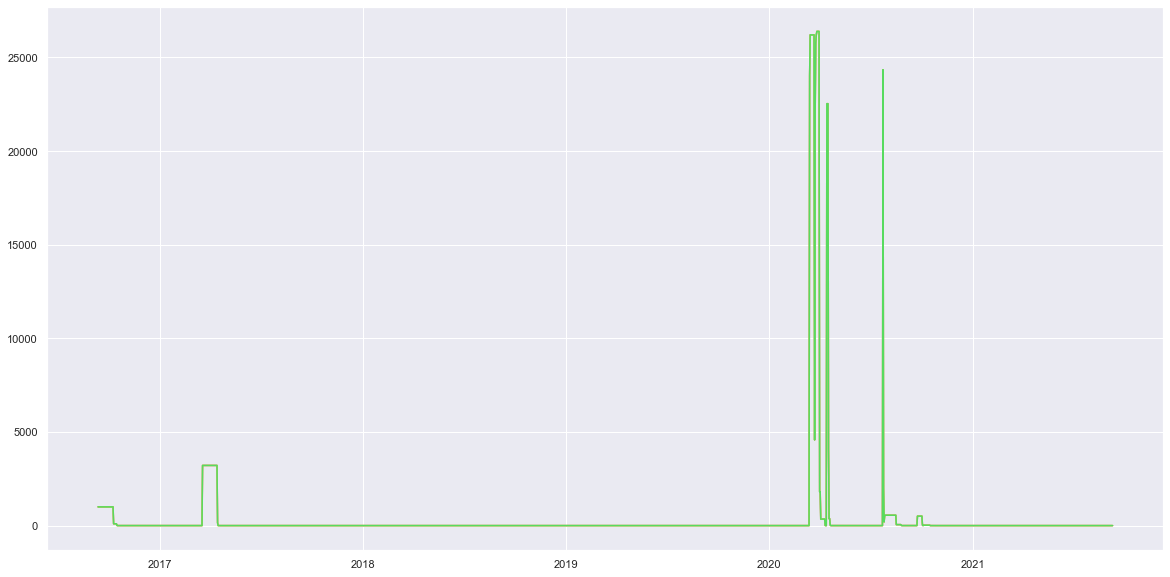

In [1764]:
plt.plot(df['Date'], df['现金持有份额'],df['Date'], df['现金持有份额'],df['Date'], df['现金持有份额'])


In [1765]:
df.to_excel('table/所有数据.xlsx')

In [ ]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
import math

# Define the model inputs
problem = {
    'num_vars': 3,
    'names': ['x1', 'x2', 'x3'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]
}


def evaluate(X):  # 这里是我们要进行灵敏度分析的模型,接受一个数组,每个数组元素作为模型的一个输入,模型的输出是一个float,干函数返回的时候再讲所有输出并起来
    return np.array([math.sin(x[0]) + x[1] * math.cos(2 * x[2]) for x in X])


# Generate samples
param_values = saltelli.sample(problem, 1000)

# Run model (example)
Y = evaluate(param_values)
print(param_values.shape, Y.shape)
# Perform analysis (这里运行完成后会自动对结果进行展示)
Si = sobol.analyze(problem, Y, print_to_console=True)
print()

# Print the first-order sensitivity indices  一阶灵敏度
print('S1:', Si['S1'])

# Print the second-order sensitivity indices   二阶灵敏度
print("x1-x2:", Si['S2'][0, 1])
print("x1-x3:", Si['S2'][0, 2])
print("x2-x3:", Si['S2'][1, 2])

